In [48]:
library(plyr)
library(ggplot2)
library(ggpubr)
library(car)
library(repr)

In [49]:
### Define functions
box_group <- function(df, group, lables){
          ggboxplot(df, x = group, y = "time", 
          color = group, palette = c("#00AFBB", "#E7B800", "#FC4E07"),
          order = lables,
          ylab = "search time(ms)", xlab = group) +
          stat_compare_means(method = "anova")
}

In [50]:
### Read csv file and define detected as time<2000
input = "CollectedData.csv"
data <- read.table(input, header = TRUE, sep = ",", 
                   col.names = c("id", "Scale", "Object", "Trajectory", "time"))
df <- data.frame(data[complete.cases(data),])
df_dect <- subset(df, time!=2000)
df$detected[df$time >= 2000] <- 'False'
df$detected[df$time <  2000] <- 'True'

### Description of the tests
The one-way analysis of variance (ANOVA) is an extension of independent two-samples t-
test for comparing means in a situation where there are more than two groups. In one-way
ANOVA, the data is organized into several groups based on one single grouping variable. The
following are ANOVA test hypotheses and assumptions.

Hypotheses of ANOVA test:
- Null hypothesis: the means of the different groups are the same.
- Alternative hypothesis: At least one sample mean is not equal to the others.

Assumptions of ANOVA test:
- The observations are obtained independently and randomly from the population dened
by the factor levels.
- The data of each factor level are normally distributed.
- These normal populations have a common variance.

### Basic statistics
Firstly, we had a general view of our observation data. As shown in the figure below, most of
the searching time lied between 250 to 750 milliseconds. Some observations close to 1000
milliseconds made the distribution a tail on the right side. Skewed data often occur due to
lower or upper bounds on the data. In our case, the distribution is skewed right since data has
a lower bound, which is 0 millisecond search time. Moreover, there is no sucient evidence
to consider those observations as outliers. Hence, we kept all the observations and continued
the following analysis.

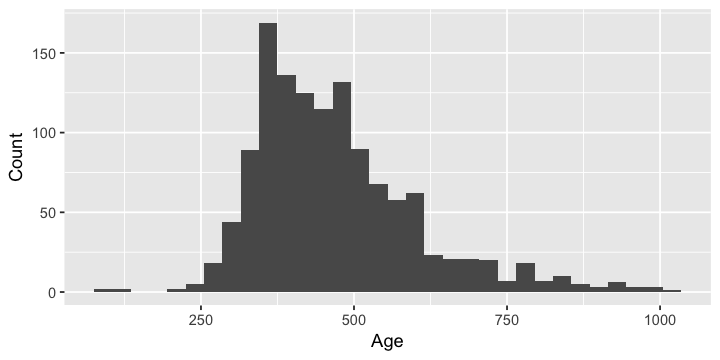

In [63]:
options(repr.plot.width=6, repr.plot.height=3)
ggplot(data=df_dect, aes(df_dect$time)) + geom_histogram(binwidth = 30) +labs(x="Age", y="Count")

[1] "Object"
[1] "Scale"


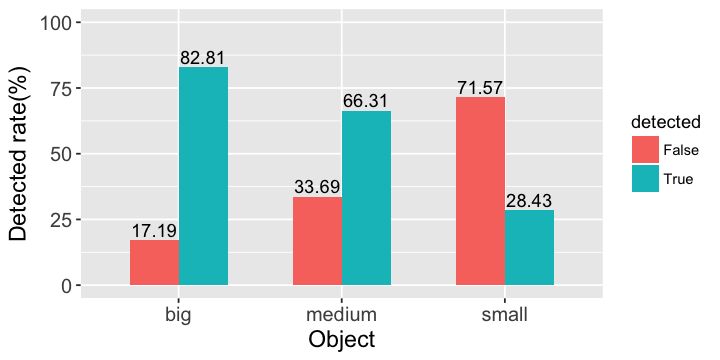

[1] "Trajectory"


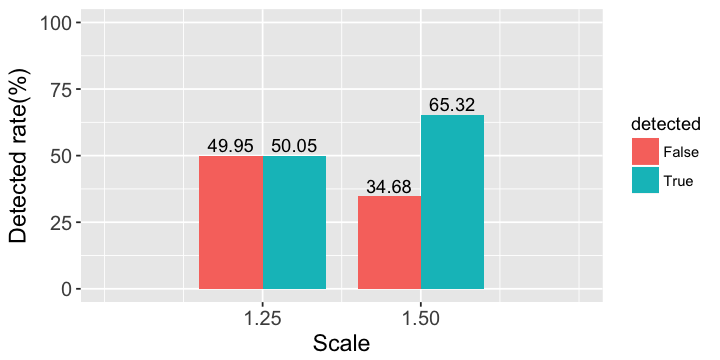

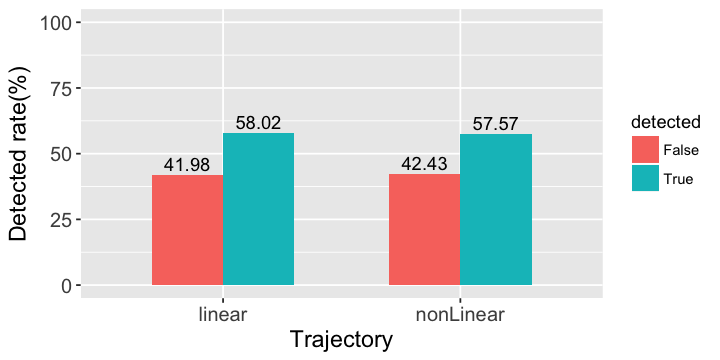

In [52]:
### Change plot size to 6 x 3
options(repr.plot.width=6, repr.plot.height=3)

### Count detected rate in different groups
list.group <- c('Object', 'Scale', 'Trajectory')

for (group in list.group){
  print(group)
  tmp <- ddply(df, c(group), transform,
        sum.n    = length(time)
  )
  group_rate <- ddply(tmp, c(group, "detected"), summarise,
        n    = length(time),
        detected_rate = (n / sum.n[1])*100,
        mean = mean(time[time != 2000]),
        sd   = sd(time[time != 2000]),
        se   = sd / sqrt(n)
  )

### Plot the detected rate in each group
{if (group == 'Scale') width=0.2
else width=0.6}

print(ggplot(group_rate, aes(fill=detected, y=detected_rate, x=eval(as.symbol(group)))) + 
             geom_bar(position="dodge", stat="identity", width = width) +
             {if (group == 'Scale') scale_x_continuous(name = group, breaks=seq(1.25, 1.5, 0.25), limits=c(1,1.75))} +
             scale_y_continuous(limits=c(0, 100)) +
             xlab(group) +
             ylab("Detected rate(%)") +
             theme(plot.title = element_text(size= 14, vjust = 1, hjust = 0.5),
                   axis.title = element_text(size=14),
                   axis.text.x = element_text(size=12),
                   axis.text.y = element_text(size=12)) + 
             geom_text(aes(label= format(round(detected_rate, 2))),  
                       position = position_dodge(width = width),
                       vjust=-0.3))
}

Then we compared the detected rate within each group. 
- The first group, which is shown in the first figure above, is the task performed by different trajectory. The detected rate (green bar) between two trajectories are very close. 
- The second group is the different scale changing of background objects. The detected rate is signifficant higher when the scale ratio increased from 1.25 to 1.5. 
- The third group shows the detected rate among different size of objects. The result shows that the detected rate is proportional to the object size, which means larger objects have higher detected rate.

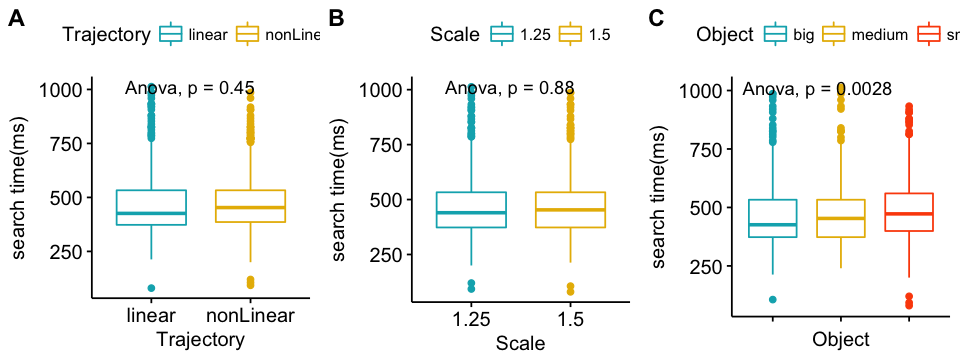

In [61]:
options(repr.plot.width=8, repr.plot.height=3)

### Box-plot of each group with Anova p-value
lables = c("linear", "nonLinear")
box_trajectory <- box_group(df_dect, "Trajectory", lables)
lables = c("1.25", "1.5")
box_scale <- box_group(df_dect, "Scale", lables)
lables = c("big", "medium", "small")
box_category <- box_group(df_dect, "Object", lables)

ggarrange(box_trajectory, box_scale, box_category + rremove("x.text"), 
          labels = c("A", "B", "C"),
          ncol = 3, nrow = 1)

- In the group of different trajectory shown in the above figure, the size and position of both box are similar, which means 50% of the data are in the same range of search time. The distribution outside of the box are also similar and both of them are skewed right as described before. The median of linear trajectory is slightly lower than nonlinear, but their mean value are very close. 
- The box plot of group of different scale ratio is pretty close to the previous one that both of the scale ratios have similar distribution.  
- The third plot of different size of objects has more differences within the group. The box and the mean value of small object is obviously higher than the other objects. In addition, the outliers of small object are less and concentrated than other objects.

### Correlation identification

In [67]:
options(repr.plot.width=4, repr.plot.height=3)
### Compute the analysis of variance(Anova) in each group
res.aov <- aov(time ~ Trajectory, data = df_dect)
# Summary of the analysis
summary(res.aov)
res.aov <- aov(time ~ Scale, data = df_dect)
# Summary of the analysis
summary(res.aov)
res.aov <- aov(time ~ Object, data = df_dect)
# Summary of the analysis
summary(res.aov)


              Df   Sum Sq Mean Sq F value Pr(>F)
Trajectory     1    10269   10269   0.577  0.447
Residuals   1263 22463671   17786               

              Df   Sum Sq Mean Sq F value Pr(>F)
Scale          1      394     394   0.022  0.882
Residuals   1263 22473546   17794               

              Df   Sum Sq Mean Sq F value Pr(>F)   
Object         2   208365  104183   5.905 0.0028 **
Residuals   1262 22265575   17643                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

We performed one-way ANOVA test, and we also tested the validity of ANOVA assumptions.
The results of ANOVA test for the 3 groups, namely trajectory group, scale group and object
group, are shown in the above tables. It is shows that group of Object is the
only group that has statistically signiffcant difference (p-value = 0.0028  0.05), which is
corresponding to our third research hypothesis.

In [69]:
# Tukey multiple pairwise-comparisons
TukeyHSD(res.aov)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = time ~ Object, data = df_dect)

$Object
                  diff        lwr      upr     p adj
medium-big    6.523322 -12.805065 25.85171 0.7080635
small-big    35.921159  11.131667 60.71065 0.0020059
small-medium 29.397837   4.214131 54.58154 0.0171732


Apart from the one-way ANOVA test, the Tukey multiple pairwise-comparisons also performed to determine if the mean difference between specific pairs of group are statistically signiffcant. It can be seen from the output shown the above table, that both the difference between small-big and small-medium are signifficant with an adjusted p-value of 0.0020 and 0.0172, respectively.

### Test validity
The ANOVA test assumes the data are normally distributed and the variance across groups are homogeneous. We can check that with the Q-Q plots.

,Df,F value,Pr(>F)
group,2,2.911096,0.05478158
,1262,NA,NA


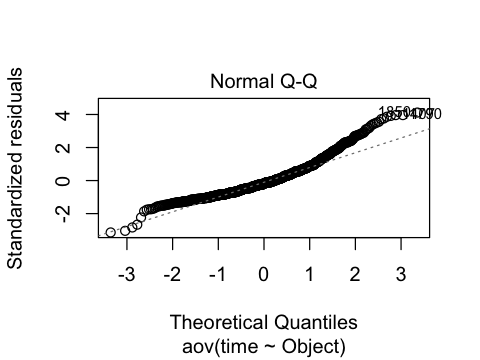

In [70]:
# Check the normality assumption
qqplot <- plot(res.aov, 2)

To check the normality assumption, the normal probability plot of residuals is used. If the
residuals are normally distributed, it should approximately follow a straight line. The normal
probability plot in the above figure shows that both tails do not fall along the reference line, which
means the data seems not normal.

In [72]:
# Shapiro test 
aov_residuals <- residuals(object = res.aov )
shapiro.test(x = aov_residuals )


	Shapiro-Wilk normality test

data:  aov_residuals
W = 0.9321, p-value < 2.2e-16


The same result also appears in Shapiro-Wilk normality test that all the
groups violate the normality.

In [73]:
# Check homogeneity of variances
leveneTest(time ~ Object, data = df_dect)

,Df,F value,Pr(>F)
group,2,2.911096,0.05478158
,1262,NA,NA


In order to check the homogeneity of variance assumption, Levene's test is performed. According to the results shown in above, all the p-value are not less than the signifficance level
of 0.05, namely there is no evidence to suggest that the variance across groups are statistically
signifficantly different. Therefore, we can assume the homogeneity of variances in the different
groups.

In [74]:
# Non-parametric alternative to one-way ANOVA test
kruskal.test(time ~ Object, data = df_dect)


	Kruskal-Wallis rank sum test

data:  time by Object
Kruskal-Wallis chi-squared = 11.161, df = 2, p-value = 0.00377


Since the normality assumptions are not met, a non-parametric alternative to one-way ANOVA
Kruskal-Wallis rank sum test is performed. The result is consistent to one-way
ANOVA that only the group of Object has statistically signifficant difference.

### Summary
We identified that the time consumption for user to notice the background change is signifficantly positive correlated with the size of the background object. There is no statistically signifficant correlation between the time consumption for users to notice the background change and the trajectory of the moving object. There is no statistically signifficant correlation between the time consumption for users to notice the background change and the scaling ration of the background object.